# Run level 2A, 2B and 3 pipelines on IMA data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) August 18th 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for IMA data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

http://ssb.stsci.edu/doc/jwst_dev/jwst/pipeline/index.html

The data files used in this notebook is a MIRISim simulation of field of point sources whose spectra are described by blackbody models.

The simulated observation is a four-point dither on the source with the F1130W filter. 

#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'IMA_demo_data'
input_dir = 'IMA_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime)
        print "\n\n"
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print "ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime)
        print "\n\n"

    # fits extension table
    hdulist.info()

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 2	 50	 FAST	 277.5



Filename: IMA_demo_data/det_image_1_MIRIMAGE_F1130Wexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     152   ()      
  1  SCI           1 ImageHDU        14   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        14   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF    1 BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF          1 ImageHDU         7   (533679145,)   uint8   


#### show the last frame of the first integration for each file

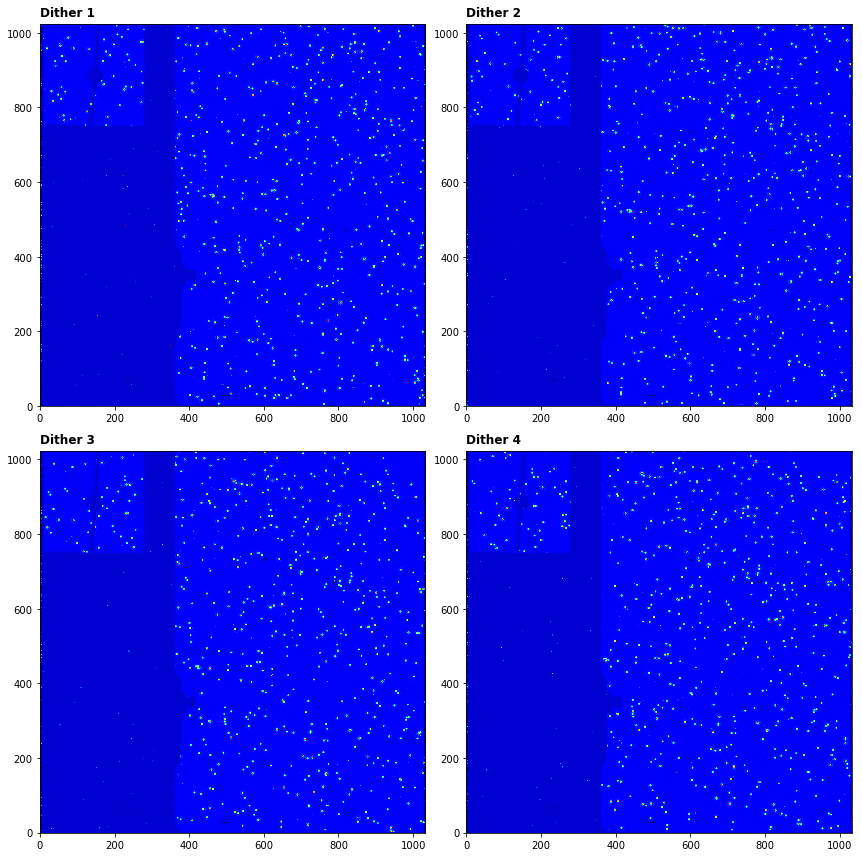

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for input_file in input_files:
    # open the input image as a jwst data model
    with datamodels.open(input_file) as in_dm:
        
        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import SloperPipeline
print SloperPipeline.__doc__



    SloperPipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    and ramp_fit.

    


For MIRI, the steps in order are: dq_init, saturation, linearity, RSCD, lastframe, dark_current, refpix, jump, ramp_fitting



#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'

NOTE: As dark current was switched off in the MIRISim simulations that produced the demo data, we will skip the dark_current step in the call to the SloperPipeline

In [6]:
for input_file in input_files:
    dm_2A = SloperPipeline.call(input_file, save_results=True, output_dir=output_dir, steps={'dark_current':{'skip':True}})
    

2017-08-25 15:20:25,498 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-08-25 15:20:25,500 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-08-25 15:20:25,502 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-08-25 15:20:25,504 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-08-25 15:20:25,505 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-08-25 15:20:25,507 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-08-25 15:20:25,510 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-08-25 15:20:25,512 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-08-25 15:20:25,514 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-08-25 15:20:25,516 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-08-25 15:20:25,517 - stpipe.SloperPipeline.dq_ini

2017-08-25 15:21:28,488 - stpipe.SloperPipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-08-25 15:21:29,808 - stpipe.SloperPipeline.jump - INFO - Executing two-point difference method
2017-08-25 15:22:50,931 - stpipe.SloperPipeline.jump - INFO - Step jump done
2017-08-25 15:22:51,657 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-08-25 15:22:51,658 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-25 15:22:51,731 - stpipe.SloperPipeline.ramp_fit - INFO - Step ramp_fit running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11cd59f90>,).
2017-08-25 15:22:52,598 - stpipe.SloperPipeline.ramp_fit - INFO - Using READNOISE reference fil

2017-08-25 15:28:21,463 - stpipe.SloperPipeline.dark_current - INFO - Step dark_current done
2017-08-25 15:28:22,031 - stpipe.SloperPipeline.refpix - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-08-25 15:28:22,115 - stpipe.SloperPipeline.refpix - INFO - Step refpix running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x19c894610>,).
2017-08-25 15:28:22,259 - stpipe.SloperPipeline.refpix - INFO - use_side_ref_pixels = True
2017-08-25 15:28:22,260 - stpipe.SloperPipeline.refpix - INFO - odd_even_columns = True
2017-08-25 15:28:22,261 - stpipe.SloperPipeline.refpix - INFO - side_smoothing_length = 11
2017-08-25 15:28:22,262 - stpipe.SloperPipeline.refpix - INFO - side_gain = 1.000000
2017-08-25 15:28:22,263 - stpipe.SloperPipeline.refpix - INFO - odd_even_rows = True
2017-08-25 15:28:22,265 - stpipe.SloperPipeline.refpix - INFO - Subtracting initial read from each integration
2017-08-25 15:28:23,675 - stpipe.SloperPipeline.refpix - INFO - Adding initial read b

2017-08-25 15:34:41,486 - stpipe.SloperPipeline.ipc - INFO - Prefetch for IPC reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_ipc_0009.fits'.
2017-08-25 15:34:41,569 - stpipe.SloperPipeline.ipc - INFO - Step ipc running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x29b73a190>,).
2017-08-25 15:34:42,090 - stpipe.SloperPipeline.ipc - INFO - Using IPC reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_ipc_0009.fits
2017-08-25 15:34:46,042 - stpipe.SloperPipeline.ipc - INFO - Step ipc done
2017-08-25 15:34:46,778 - stpipe.SloperPipeline.linearity - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2017-08-25 15:34:46,851 - stpipe.SloperPipeline.linearity - INFO - Step linearity running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x1760d8a50>,).
2017-08-25 15:34:47,363 - stpipe.SloperPipeline.linearity -

2017-08-25 15:41:31,810 - stpipe.SloperPipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-08-25 15:41:31,812 - stpipe.SloperPipeline.persistence - INFO - PersistenceStep instance created.
2017-08-25 15:41:31,814 - stpipe.SloperPipeline.superbias - INFO - SuperBiasStep instance created.
2017-08-25 15:41:32,060 - stpipe.SloperPipeline - INFO - Step SloperPipeline running with args ('IMA_demo_data/det_image_4_MIRIMAGE_F1130Wexp1.fits',).
2017-08-25 15:41:32,062 - stpipe.SloperPipeline - INFO - Starting calwebb_sloper ...
2017-08-25 15:41:33,383 - stpipe.SloperPipeline.group_scale - INFO - Step group_scale running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x21c060fd0>,).
2017-08-25 15:41:33,517 - stpipe.SloperPipeline.group_scale - WARNING - NFRAMES=1 is a power of 2
2017-08-25 15:41:33,519 - stpipe.SloperPipeline.group_scale - WARNING - Step will be skipped
2017-08-25 15:41:33,526 - stpipe.SloperPipeline.group_scale - INFO - Step group_scale done
201

2017-08-25 15:43:57,652 - stpipe.SloperPipeline.ramp_fit - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-08-25 15:43:57,682 - stpipe.SloperPipeline.ramp_fit - INFO - Using algorithm = ols
2017-08-25 15:43:57,683 - stpipe.SloperPipeline.ramp_fit - INFO - Using weighting = optimal
2017-08-25 15:43:57,713 - stpipe.SloperPipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2017-08-25 15:48:32,076 - stpipe.SloperPipeline.ramp_fit - INFO - Number of groups per integration: 50
2017-08-25 15:48:32,077 - stpipe.SloperPipeline.ramp_fit - INFO - Number of integrations: 2
2017-08-25 15:48:32,260 - stpipe.SloperPipeline.ramp_fit - INFO - Step.save_model IMA_demo_data_pipelined/det_image_4_MIRIMAGE_F1130Wexp1_rateints.fits
2017-08-25 15:48:32,398 - stpipe.SloperPipeline.ramp_fit - INFO - Step ramp_fit done
2017-08-25 15:48:32,399 - stpipe.SloperPipeline - INFO - ... ending calwebb_sloper
2017-08-25 15:48:32

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print'Check step information status:'
    print 'dq_init: %s' % dm.meta.cal_step.dq_init
    print 'saturation: %s' % dm.meta.cal_step.saturation
    print 'linearity: %s' % dm.meta.cal_step.linearity
    print 'rscd: %s' % dm.meta.cal_step.rscd
    print 'lastframe: %s' % dm.meta.cal_step.lastframe
    print 'dark_current: %s' % dm.meta.cal_step.dark_sub
    print 'refpix: %s' % dm.meta.cal_step.refpix
    print 'jump: %s' % dm.meta.cal_step.jump
    print 'ramp_fit: %s' % dm.meta.cal_step.ramp_fit

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: None
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Image2Pipeline
print Image2Pipeline.__doc__


    Image2Pipeline: Processes JWST imaging-mode slope data from Level-2a to
    Level-2b.

    Included steps are:
    assign_wcs, flat_field, and photom.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'

In [9]:
for f in level2A_files:
    dm_2B = Image2Pipeline.call(f, save_results=True, output_dir=output_dir)
    

2017-08-25 15:48:32,809 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2017-08-25 15:48:32,812 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-08-25 15:48:32,814 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2017-08-25 15:48:32,817 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2017-08-25 15:48:33,129 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('IMA_demo_data_pipelined/det_image_1_MIRIMAGE_F1130Wexp1_rate.fits',).
2017-08-25 15:48:33,130 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...
2017-08-25 15:48:33,256 - stpipe.Image2Pipeline - INFO - Processing product IMA_demo_data_pipelined/det_image_1_MIRIMAGE_F1130Wexp1
2017-08-25 15:48:33,257 - stpipe.Image2Pipeline - INFO - Working on input IMA_demo_data_pipelined/det_image_1_MIRIMAGE_F1130Wexp1_rate.fits ...
2017-08-25 15:48:34,078 - stpipe.Image2Pipeline.assign_wcs - INFO - Prefetch for CAMERA r

2017-08-25 15:48:39,973 - stpipe.Image2Pipeline.assign_wcs - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/asdf/asdftypes.py:262: UserWarning: 'tag:stsci.edu:asdf/transform/polynomial' with version 1.0.0 found in file 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf', but latest supported version is 1.1.0
  warnings.warn(warning_string.format(fname))

2017-08-25 15:48:39,974 - stpipe.Image2Pipeline.assign_wcs - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/asdf/asdftypes.py:240: UserWarning: 'tag:stsci.edu:asdf/transform/polynomial' with version 1.0.0 found in file 'file:///Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf', but latest supported version is 1.1.0
  warnings.warn(warning_string.format(fname))

2017-08-25 15:48:40,510 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2017-08-25 15:48:40,587 - stp

2017-08-25 15:48:53,644 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<jwst.datamodels.image.ImageModel object at 0x29b7e6450>,).
2017-08-25 15:48:54,321 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-25 15:48:54,323 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-25 15:48:54,324 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-25 15:48:54,334 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-25 15:48:54,704 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2017-08-25 15:48:55,410 - stpipe.Image2Pipeline.photom - INFO - Prefetch for AREA reference file is 

2017-08-25 15:49:09,148 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits
2017-08-25 15:49:09,149 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2017-08-25 15:49:09,150 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2017-08-25 15:49:09,151 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2017-08-25 15:49:09,152 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W
2017-08-25 15:49:09,202 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2017-08-25 15:49:09,270 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2017-08-25 15:49:09,272 - stpipe.Image2Pipeline.photom - INFO - Writing PHOTMJSR with value: 2.44947
2017-08-25 15:49:09,340 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2017-08-25 15:49:09,342 - stpipe.Image2Pipeline - INFO - Finished processing product IMA_demo_data_pipelined/det_image_3_MIRIMAGE_F11

#### Quick check of the pipeline steps applied in the level 2B output. We'll look at the first dither:

In [10]:
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print'Check step information status:'
    print 'assign_wcs: %s' % dm.meta.cal_step.assign_wcs
    print 'flat_field: %s' % dm.meta.cal_step.flat_field
    print 'photom: %s' % dm.meta.cal_step.photom


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

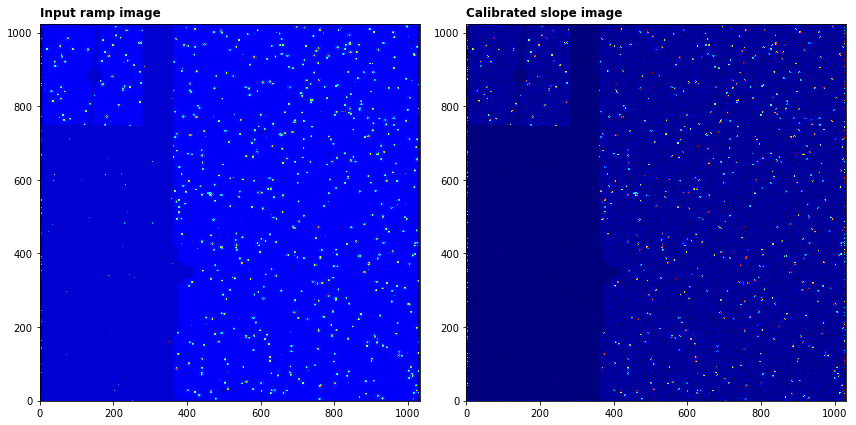

In [11]:
# open the input image as a jwst data model
with datamodels.open(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

### Level 3 pipeline
We first create an association file in the output directory containing the list of level 2B files ('_cal.fits') produced by the level 2B pipeline. We can then combine the dithers with the Image3Pipeline. Note the the image alignment step tweakreg is currently not working. Therefore, we skip this step and the associated tweakreg_catalog step. 

The output drizzled image file will be contained in 'ima_dither_i2d.fits' with the source list contained in 'ima_dither_cat.escv'.

#### create the level 3 association using the asn_from_list tool

In [12]:
#for n,cal_file in enumerate(cal_files): cal_files[n] = os.path.basename(cal_file)
call(["asn_from_list", "-o", "IMA_asn.json"] + level2B_files + ["--product-name", "ima_dither"])


0

#### import the level 3 pipeline class and print description

In [13]:
from jwst.pipeline import Image3Pipeline
print Image3Pipeline.__doc__


    Image3Pipeline: Applies level 3 processing to imaging-mode data from
                    any JWST instrument.

    Included steps are:
        tweakreg_catalog
        tweakreg
        skymatch
        outlier_detection
        resample
        source_catalog
    


#### run pipeline

In [14]:
dm_3_container = datamodels.ModelContainer("IMA_asn.json")

Image3Pipeline.call(dm_3_container, save_results=True, steps={'tweakreg':{'skip':True},'tweakreg_catalog':{'skip':True}})

# move the Image3Pipeline output to the output_dir
for file in glob.glob('*a3001.fits'): shutil.move(file,os.path.join(output_dir,file))
shutil.move('ima_dither_i2d.fits',os.path.join(output_dir,'ima_dither_i2d.fits'))
shutil.move('IMA_asn.json',os.path.join(output_dir,'IMA_asn.json'))
shutil.move('ima_dither_cat.escv',os.path.join(output_dir,'ima_dither_cat.escv'))

2017-08-25 15:49:29,674 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2017-08-25 15:49:29,677 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2017-08-25 15:49:29,679 - stpipe.Image3Pipeline.tweakreg_catalog - INFO - TweakregCatalogStep instance created.
2017-08-25 15:49:29,683 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2017-08-25 15:49:29,686 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2017-08-25 15:49:29,688 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2017-08-25 15:49:29,691 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2017-08-25 15:49:29,835 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args (<jwst.datamodels.container.ModelContainer object at 0x11fc161d0>,).
2017-08-25 15:49:29,836 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...
2017-08-25 15:49:32,513 - stpipe.Ima

2017-08-25 15:49:55,381 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done
2017-08-25 15:49:55,383 - stpipe.Image3Pipeline - INFO - Writing Level 2c images with updated DQ arrays...
2017-08-25 15:49:55,384 - stpipe.Image3Pipeline - INFO - Step.save_model det_image_1_MIRIMAGE_F1130Wexp1_cal-a3001.fits
2017-08-25 15:49:55,847 - stpipe.Image3Pipeline - INFO - Step.save_model det_image_2_MIRIMAGE_F1130Wexp1_cal-a3001.fits
2017-08-25 15:49:56,268 - stpipe.Image3Pipeline - INFO - Step.save_model det_image_3_MIRIMAGE_F1130Wexp1_cal-a3001.fits
2017-08-25 15:49:56,696 - stpipe.Image3Pipeline - INFO - Step.save_model det_image_4_MIRIMAGE_F1130Wexp1_cal-a3001.fits
2017-08-25 15:49:57,107 - stpipe.Image3Pipeline - INFO - Resampling images to final output...
2017-08-25 15:49:57,994 - stpipe.Image3Pipeline.resample - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2017-08-25 15:49:58,47

#### plot the drizzled file

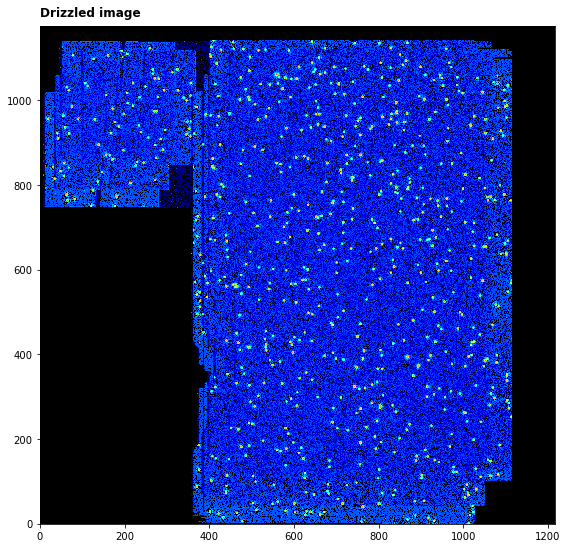

In [15]:
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

#### look at the source list 

In [16]:
from astropy.table import Table

my_catalog = os.path.join(output_dir,'ima_dither_cat.escv')
sources = Table.read(my_catalog, format='ascii.ecsv')

print sources

 id   xcentroid     ycentroid   ... orientation_sky     abmag     abmag_error
         pix           pix      ...       deg                                
--- ------------- ------------- ... --------------- ------------- -----------
  1 1011.47880844 1.58389221767 ...   275.393980462  17.500120163   0.0160891
  2 758.511706103 5.43425928145 ...   217.949256303 16.3200263977  0.00773224
  3 477.034542413 6.20267955505 ...   310.318164025 16.6953487396   0.0099828
  4 929.566141689 6.87046455532 ...   295.050649835  16.113740921  0.00669588
  5 866.994640495 10.2198407872 ...   213.004829156 16.8549098969   0.0116823
  6 916.560498459 13.9049354249 ...    217.09133171 16.0727100372  0.00645293
  7 432.072671567 15.0863350439 ...   306.131217052 15.7525548935  0.00512238
  8 884.991988134 19.5190252227 ...   345.939233457 16.3574733734  0.00782187
  9 627.139361903 24.0081585592 ...   342.251502182 15.6233005524  0.00578054
 10 661.042375209 21.3563212738 ...   337.842002174 15.922687530

#### plot the source list over the drizzled image

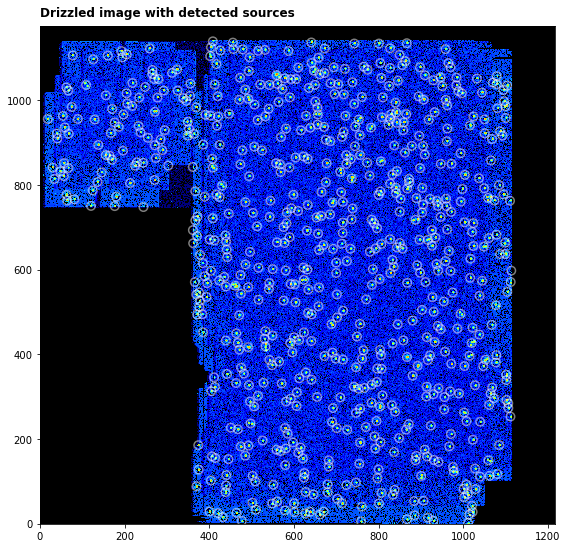

In [17]:
from astropy.table import Table
from photutils import CircularAperture

# read source X,Y positions from the table, show with circles of radius 10pix
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=10.)

# image
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
apertures.plot(color='white', lw=1.5, alpha=0.5)
axs.annotate('Drizzled image with detected sources', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()